In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Toxicity_analysis_neural

/content/drive/MyDrive/Toxicity_analysis_neural


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,callbacks
import random, time

Reading the data

In [4]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


EDA

Distribution of lables

In [5]:
labels = [label for label in df.columns][2:]
labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [12]:
# Calculate positive_class_ratio
num_rows = len(df)
positive_class_ratio = round(100*df[df.columns[2:]].sum()/num_rows,2).sort_values()

# Plot with Plotly
fig = px.bar(positive_class_ratio, x=positive_class_ratio.index, y= positive_class_ratio.values,
             title="Distribution of labels",height=400,width=800)
fig.update_xaxes(title="label")
fig.update_yaxes(title="%")
fig.update_layout(
            title_text="<b>Distribution of labels</b>",
            title_x=0.5,
            title_font_color="black",
            font=dict(color="black")  ,
            margin=dict(r=20, t=90, b=40, l=20),
        )
fig.show()

Length of the comments- number of words

In [13]:
# Add column "comment_length"
df["comment_length"] = df["comment_text"].apply(lambda x:len(x.split()))

In [14]:
# Distribution of comment lengths
fig = px.histogram(df["comment_length"],title="Distribution of comment lengths",nbins=100,histnorm="percent")
fig.show()

p_95 = int(np.percentile(df["comment_length"].values,95)) # the 95th percentile
print(f"95% of the comments have less than {p_95} words. Few comments have very high length.")

95% of the comments have less than 230 words. Few comments have very high length.


In [15]:
# Distribution of comment lengths per Label

fig = make_subplots(rows=2, cols=3,
                    subplot_titles=tuple(labels) )

col_id = 0
row_id = 1

for i in range(6):
    comments_i = df.loc[df[labels[i]] == 1, :]['comment_length']
    p_95 = int(np.percentile(comments_i,95)) # the 95th percentile
    comments_i = comments_i[comments_i<p_95]
    print(f"95% of the comments for label '{labels[i]}' have less than {p_95} words.")

    # add subplot
    fig.add_trace(
        go.Histogram(x=comments_i, marker=dict(color="#636EFA"),showlegend=False,name=labels[i],
                     nbinsx=250,histnorm="percent"),
        row=row_id, col=1+col_id
    )
    fig.update_yaxes(title_text="%", row=row_id, col=1+col_id)
    col_id +=1
    if col_id ==3:
        col_id = 0
        row_id = 2

# update layout
fig.update_layout(
    title_text = "<b>Distribution of comment lengths per Label (95th percentile)<b>",
    title_x=0.5,
    title_font_color="black",
    font=dict(color="black")  ,
    margin=dict(r=20, t=90, b=40, l=20),
    height=450)

fig.show()

95% of the comments for label 'toxic' have less than 171 words.
95% of the comments for label 'severe_toxic' have less than 473 words.
95% of the comments for label 'obscene' have less than 162 words.
95% of the comments for label 'threat' have less than 143 words.
95% of the comments for label 'insult' have less than 151 words.
95% of the comments for label 'identity_hate' have less than 178 words.


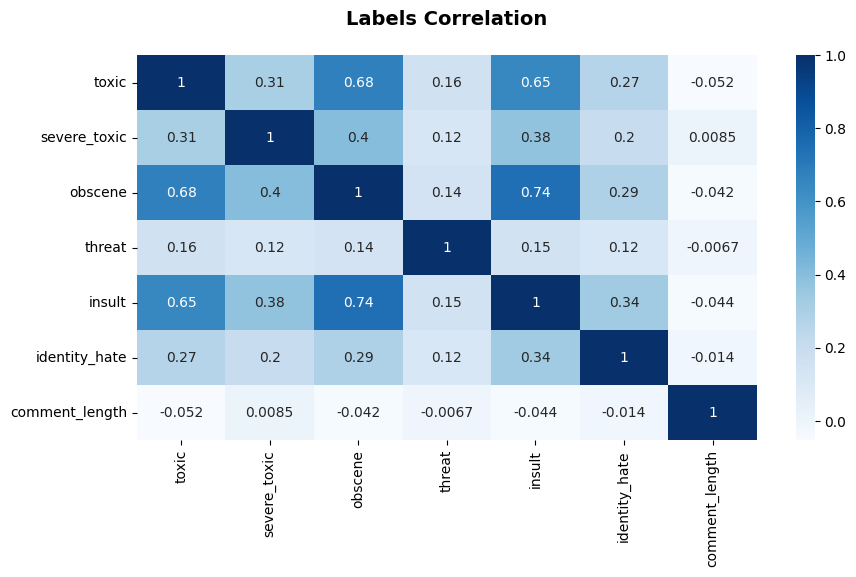

In [17]:
labels_cor = df.drop(["id","comment_text"],axis=1).corr(numeric_only=True)

plt.figure(figsize=(10,5))
sns.heatmap(labels_cor, annot=True, cmap='Blues')
plt.title("Labels Correlation\n",size = 14, weight = 'bold')
plt.show()

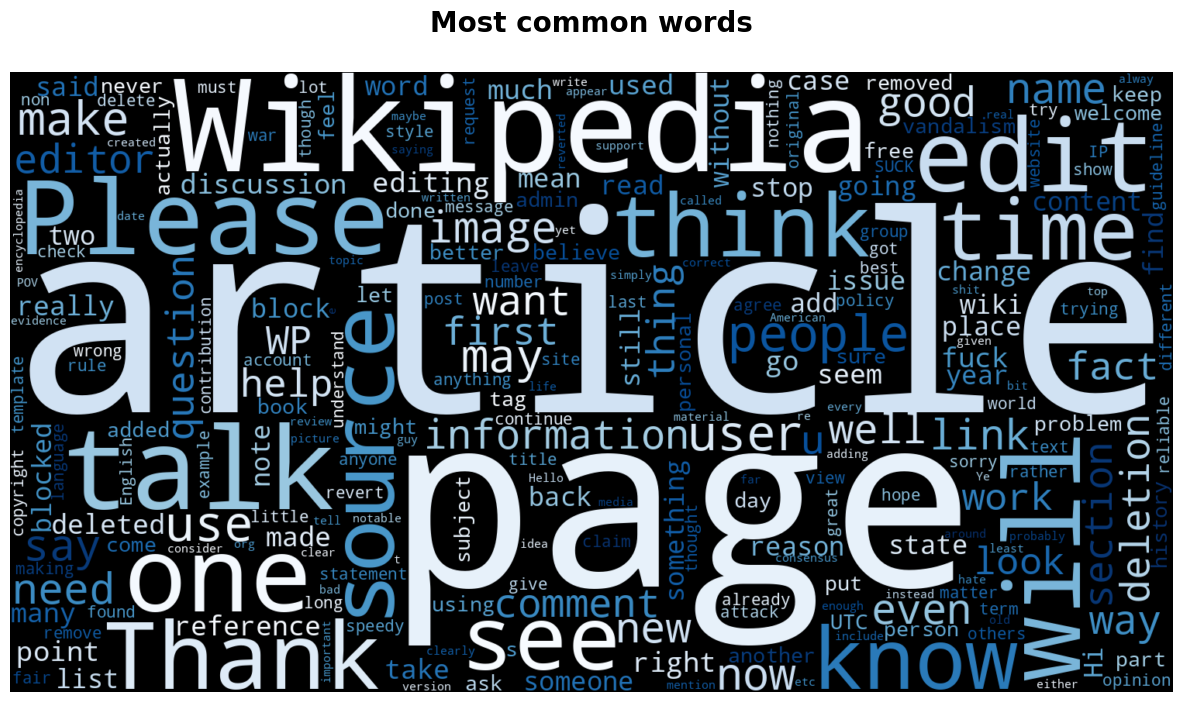

In [19]:
all_comments =  pd.Series(df["comment_text"]).str.cat(sep=' ')

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='black',max_words=250,
                      width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
wordcloud.generate(all_comments)

# display the wordcloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common words\n",size = 20, weight = 'bold')
plt.show()

Most common toxic words using word cloud

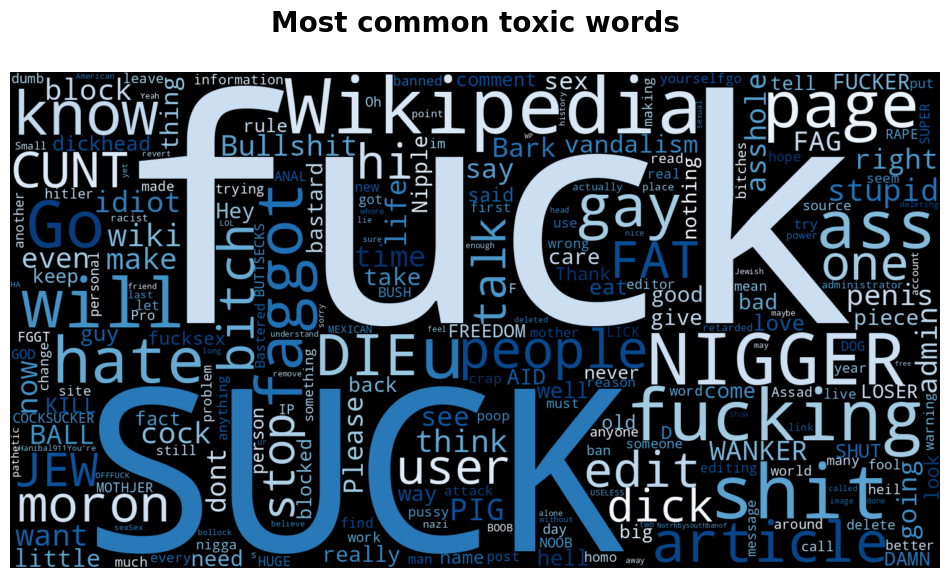

In [22]:
toxic_comments = df[df[labels].sum(axis=1)>0]["comment_text"] # at least on label is positive
toxic_text = pd.Series(toxic_comments).str.cat(sep=' ')

from wordcloud import WordCloud
toxic_wordcloud = WordCloud(background_color='black',max_words=250,
                            width=1500,height=800,max_font_size=500,collocations=False)
# Generate the word cloud
toxic_wordcloud.generate(toxic_text)


plt.figure(figsize=(12, 10))
plt.imshow(toxic_wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
plt.axis("off")
plt.title(f"Most common toxic words\n",size = 20, weight = 'bold')
plt.show()

In [23]:
toxic_wordclouds = []
for i in range(6):
    toxic_comments_i = df.loc[df[labels[i]] == 1, :]["comment_text"] # at least on label is positive
    toxic_text_i = pd.Series(toxic_comments_i).str.cat(sep=' ')

    toxic_wordcloud_i = WordCloud(max_words=200)
    # Generate the word cloud
    toxic_wordcloud_i.generate(toxic_text_i)
    toxic_wordclouds.append(toxic_wordcloud_i.words_)

toxic_wordclouds_df = pd.DataFrame(toxic_wordclouds).T.round(2).fillna(0)
toxic_wordclouds_df.columns = labels

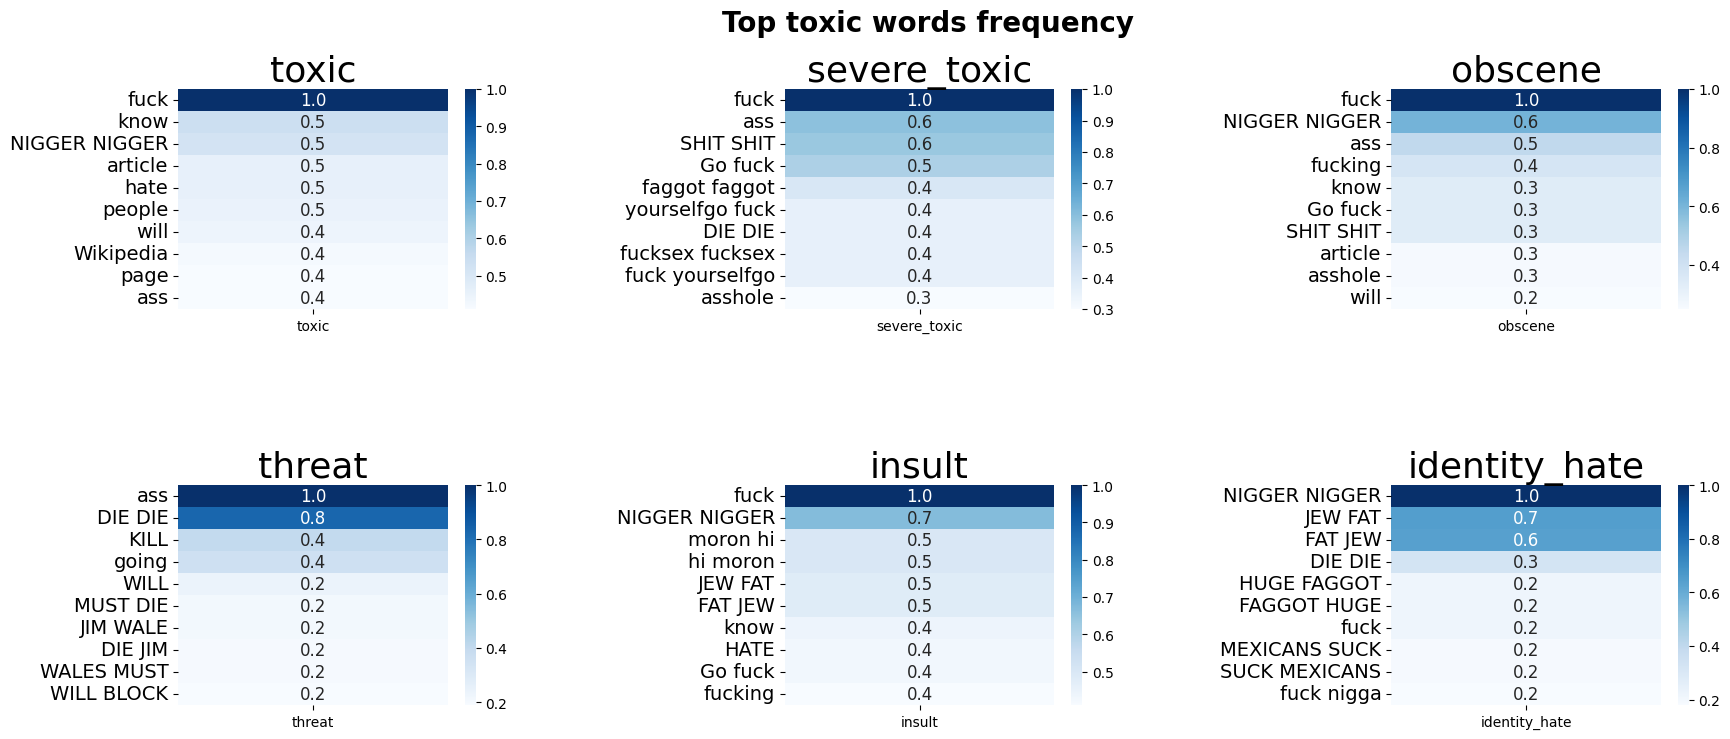

In [25]:

selected_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_wordclouds_selected = toxic_wordclouds_df[selected_labels]

fig, ax = plt.subplots(2, 3, figsize=(20,8), sharex=False)
plt.subplots_adjust(wspace=0.8,hspace=0.8)
fig.suptitle('Top toxic words frequency', fontsize=20, weight = 'bold')

axes =ax.ravel()
for i in range(6):
    label = selected_labels[i]
    top_words_i = pd.DataFrame(toxic_wordclouds_selected[label].sort_values(ascending=False)[:10])
    sns.heatmap(top_words_i, fmt='.01f', annot=True,cmap="Blues",ax=axes[i],annot_kws={"size": 12})

    axes[i].title.set_text(selected_labels[i])
    axes[i].title.set_size(26)
    axes[i].tick_params(axis='y', labelsize=14)

plt.show()

Data Preprocessing

In [30]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Downloading required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # For wordnet lemmatizer support across languages (optional)

def clean_text(text):
    # 1. Find URLs and replace them with 'urlplaceholder'
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, 'urlplaceholder', text)

    # 2. Convert to lowercase and strip whitespace
    text = text.lower().strip()

    # 3. Remove punctuation and non-alphanumeric characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    clean_tokens = [word for word in text.split() if word not in stop_words]

    # 6. Lemmatization
    lemmatizer = WordNetLemmatizer()
    # 6.1 Reduce words to their root form
    lemmed = [lemmatizer.lemmatize(w) for w in clean_tokens]
    # 6.2 Lemmatize verbs by specifying POS tag as 'v'
    clean_tokens = [lemmatizer.lemmatize(w, pos='v') for w in lemmed]

    cleaned_text = ' '.join(clean_tokens)

    return cleaned_text

# Measure execution time for applying the clean_text function
start = time.time()
df["clean_comment"] = df["comment_text"].apply(clean_text)
end = time.time()
print(f"Execution time: {int((end-start)/60)} minutes and {int((end-start)%60)} seconds")

df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Execution time: 1 minutes and 32 seconds


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length,clean_comment
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,43,explanation edit make username hardcore metall...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,17,aww match background colour seemingly stick th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,hey man really try edit war guy constantly rem...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,113,make real suggestion improvement wonder sectio...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,sir hero chance remember page


Iterative train test split

In [32]:
!pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

# Split into X and y
X = df[['clean_comment','comment_text']].to_numpy()
# X = df[['clean_comment']].to_numpy()
y = df[labels].to_numpy()

X_train, y_train, X_test, y_test = iterative_train_test_split(X.reshape((len(df), -1)), y, test_size = 0.3)

X_train = tf.squeeze(X_train).numpy()
y_train = tf.squeeze(y_train).numpy()
X_test = tf.squeeze(X_test).numpy()
y_test = tf.squeeze(y_test).numpy()

print(f"X shape:",X.shape)
print(f"X_train shape:",X_train.shape)
print(f"X_test shape:",X_test.shape)
print(f"y_train shape:",y_train.shape)
print(f"y_test shape:",y_test.shape)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00
X shape: (159571, 2)
X_train shape: (111699, 2)
X_test shape: (47872, 2)
y_train shape: (111699, 6)
y_test shape: (47872, 6)


claculate class weights

In [33]:
class_0_weights = []
class_1_weights = []

for c in labels:
    class_0_weights.append(df.shape[0]/(2*np.count_nonzero(df[c]==0)))
    class_1_weights.append(df.shape[0]/(2*np.count_nonzero(df[c]==1)))
weights = np.array([class_0_weights,class_1_weights]).T
weights

array([[  0.55300221,   5.21678436],
       [  0.50504824,  50.02225705],
       [  0.52795424,   9.44318854],
       [  0.50150227, 166.91527197],
       [  0.52596345,  10.12891964],
       [  0.50444154,  56.78683274]])

TextVectorization and Embedding

TextVectorization

In [54]:
from keras.layers import TextVectorization
import numpy as np
import pandas as pd
import plotly.express as px

def Text_Vectorization(X_train_array):
    # Ensure the input is a 1D array of text data
    X_train_array = X_train_array[:, 0]  # Assuming text data is in the first column

    # 1. Set the `Output_sequence_length` parameter
    clean_Tokens_length = [len(str(sentence).split()) for sentence in X_train_array]

    clean_Tokens_length_df = pd.DataFrame(clean_Tokens_length, columns=['len'])
    fig = px.histogram(clean_Tokens_length_df, x="len", title="Tokens length")
    fig.show()

    SEQ_tokens_length = int(np.percentile(clean_Tokens_length, 95))
    print(f"SEQ_tokens_length:", SEQ_tokens_length)

    # 2. How many words are in our vocabulary?
    list_tokens = []
    for sentence in X_train_array:
        for token in str(sentence).split():
            list_tokens.append(token)
    set_tokens = set(list_tokens)

    MAX_tokens = len(set_tokens)
    print(f"MAX_tokens:", MAX_tokens)

    # 3. TextVectorization
    tokens_TextVectorization = TextVectorization(max_tokens=MAX_tokens, output_sequence_length=SEQ_tokens_length)
    # Adapt text vectorizer to training sentences
    tokens_TextVectorization.adapt(X_train_array)

    # Get Vocabulary
    words_in_vocab = tokens_TextVectorization.get_vocabulary()
    print(f"Number of words in vocab: {len(words_in_vocab)}")
    print(f"Top 5 most common words: {words_in_vocab[:5]}")
    print(f"Bottom 5 least common words: {words_in_vocab[-5:]}")

    return SEQ_tokens_length, MAX_tokens, tokens_TextVectorization, words_in_vocab


In [55]:
SEQ_tokens_length,MAX_tokens,tokens_TextVectorization,words_in_vocab = Text_Vectorization(X_train)

SEQ_tokens_length: 119
MAX_tokens: 150493
Number of words in vocab: 124130
Top 5 most common words: ['', '[UNK]', 'article', 'page', 'wikipedia']
Bottom 5 least common words: ['00009c', '00008b', '000045', '000002000004000008000016', '000001']


Embedding

In [56]:
from keras.layers import Embedding
tokens_Embedding = Embedding(input_dim=MAX_tokens,
                             input_length=SEQ_tokens_length,
                             output_dim=128,mask_zero=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



In [57]:
# Show an embedding example

# Get a random comment from training set
random_comment = random.choice(X_train)
print(f"Original text:\n{random_comment}\
      \n\nEmbedded version:")

# Embed the random sentence
sample_embed = tokens_Embedding(tokens_TextVectorization(random_comment))
sample_embed

Original text:
[b'charles knight anal king proof'
 b'Charles Knight is an anal king \n\nI have proof.']      

Embedded version:


<tf.Tensor: shape=(2, 119, 128), dtype=float32, numpy=
array([[[-0.01544421, -0.03679577, -0.01487032, ...,  0.02309263,
          0.03740417, -0.04745952],
        [-0.03954735,  0.02572738, -0.00659544, ...,  0.00604177,
          0.04990562,  0.02076778],
        [ 0.00958727, -0.02426555,  0.00014725, ..., -0.02425076,
         -0.00419154, -0.03028666],
        ...,
        [ 0.04539776, -0.00088061,  0.0285329 , ..., -0.00017891,
          0.00536323,  0.04138819],
        [ 0.04539776, -0.00088061,  0.0285329 , ..., -0.00017891,
          0.00536323,  0.04138819],
        [ 0.04539776, -0.00088061,  0.0285329 , ..., -0.00017891,
          0.00536323,  0.04138819]],

       [[-0.01544421, -0.03679577, -0.01487032, ...,  0.02309263,
          0.03740417, -0.04745952],
        [-0.03954735,  0.02572738, -0.00659544, ...,  0.00604177,
          0.04990562,  0.02076778],
        [ 0.02323047, -0.03489696, -0.01295031, ...,  0.03512409,
         -0.04760414,  0.01659575],
        ...,

Create datasets

In [59]:
# Turn our data into TensorFlow Datasets
BATCH_size = 512
AUTO = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(BATCH_size).prefetch(AUTO)
train_dataset_aug = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(BATCH_size).prefetch(AUTO)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(BATCH_size).prefetch(AUTO)

Create functions to train and evaluate our models

In [60]:
def build_model(model_layers,model_name,loss_function):
    tf.random.set_seed(42)
    inputs = layers.Input(shape=[],dtype=tf.string)
    x = tokens_TextVectorization(inputs)
    tokens_Embedding = Embedding(input_dim=MAX_tokens,
                                 input_length=SEQ_tokens_length,
                                 output_dim=128,mask_zero=True)
    x = tokens_Embedding(x)

    for layer in model_layers:
        x = layer(x)

    outputs = layers.Dense(len(labels),activation="sigmoid")(x)
    model = keras.Model(inputs,outputs,name=model_name)

    model.compile(loss = loss_function,
                   optimizer=keras.optimizers.Adam(),
                   metrics=['accuracy',
                            keras.metrics.AUC(multi_label=True,name='auc'),
                            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                           ])
    model.summary()
    return model


def compile_model(model,loss_function,learnin_rate):
    model.compile(loss = loss_function,
                   optimizer=keras.optimizers.Adam(learning_rate=learnin_rate),
                   metrics=['accuracy',
                            keras.metrics.AUC(name='auc'),
                            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
                           ])

In [61]:
def train_model(model,train_dataset,test_dataset,epochs):

    # 1. Callbacks
    model_ckpt = keras.callbacks.ModelCheckpoint("./models_ckpt/"+model.name,
                                                 save_best_only=True,save_weights_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=4,monitor='val_loss',
                                                   verbose=1,
                                                   restore_best_weights=True)

    reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=2,monitor='val_loss', factor=0.2,min_lr=1e-7)

    # 2. Train the model
    history = model.fit(train_dataset,epochs=epochs,
                        validation_data=test_dataset,
                        callbacks=[model_ckpt,early_stopping,reduce_lr])
    # save history
    # pd.DataFrame(history.history).to_csv("./stats/history_"+model.name+".csv",index=False)

    # 3. Load the best model
    try:
        # model = keras.models.load_model("./models_ckpt/"+model.name,
        #                                 custom_objects={'loss': get_weighted_loss(weights)})
        model.load_weights("./models_ckpt/"+model.name)
        print("The best model is loaded...")
    except:
        print("Error loading the best model!")

    return history

In [62]:
def plot_metrics(history,model_name,list_metrics=['loss','auc']):
    """Plot list of metrics"""
    for metric in list_metrics:
        train_metric = history.history[metric]
        val_metric = history.history[f"val_{metric}"]
        epochs = range(len(history.history[metric]))

        plt.figure(figsize=(7, 5))
        plt.plot(epochs, train_metric, label=f"training_{metric}")
        plt.plot(epochs, val_metric, label=f"val_{metric}")
        plt.title(f"{str.upper(metric)} - {model_name}")
        plt.xlabel('Epochs')
        plt.legend()

In [63]:
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score,\
                        precision_recall_fscore_support,classification_report

def evaluate_model(probs,preds,y_true,labels,label_inedx,plot_ROC_AUC=False):
    """
    - Print AUC, accuracy, precision, recall, and f1_score on the test set
    - Plot ROC AUC

    Parameters
    -----------
        probs: an array of predicted probabilities
        preds: an array of predictions
        y_true: true y values
        labels (list): model's labels (toxic, severe_toxic, obscene, threat, insult, identity_hate)
        label_inedx (int): label index, in range(0,6)
        plot_ROC_AUC (boolean): plot ROC AUC or not, default=False
    """

    y_probs = probs[:, label_inedx]
    y_pred = preds[:, label_inedx]
    y_true = y_true[:,label_inedx]

    print(f"\n{labels[label_inedx]}:")
    print("#"*50)

    fpr, tpr, threshold = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Get precision, recall, and F-measure
    precision,recall,f1_score,_, = precision_recall_fscore_support(y_true, y_pred,average="weighted")
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1_score: {f1_score:.4f}')

    # Plot ROC AUC
    if plot_ROC_AUC:
        plt.figure()
        plt.title(f"Receiver Operating Characteristic - {labels[label_inedx]}")
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [64]:
def get_metrics_per_class(y_test, y_pred,probs,model_name,labels):
    """
    Build a dataframe showing the main classification metrics
        per label (toxic, severe_toxic...) and class (0, 1 and weigted avg).
    Metrics: Accuracy, ROC, f1_score,precision

    Parameters
    -----------
        y_test: true y values
        y_pred: predicted y values
        probs: an array of predicted probabilities
        model_name (str): the model name
        labels (list): model's labels (toxic, severe_toxic, obscene, threat, insult, identity_hate)

    Returns
    ----------- :
        df_metrics_report: A dataframe containing classification metrics
            per category (toxic, severe_toxic...) and class (0, 1 and weigted avg)
    """

    class_list = ["0","1","weighted avg"]
    reports_list = []

    for indice,category in enumerate(labels):
        # 1. calssification report
        report = classification_report(y_test[:,indice], y_pred[:,indice], output_dict=True)

        # 2. accuracy
        try:
            accuracy = accuracy_score(y_test[:,indice], y_pred[:,indice])
        except:
            accuracy = np.nan

        # 3. roc_auc_score
        try:
            roc = roc_auc_score(y_test[:,indice], probs[:,indice])
        except:
            roc = np.nan

        # 4. Build the list of dicts (will be used to create a dataframe)
        for class_name in class_list:
            try:
                report_class = report.get(class_name)

                # Accuracy and roc_auc scores are available only for weighted avg
                if class_name == "weighted avg":
                    report_class["accuracy"] = accuracy
                    report_class["ROC"] = roc
                else:
                    report_class["accuracy"] = np.nan
                    report_class["ROC"] = np.nan

                report_class["category"] = category
                report_class['class'] = class_name
                report_class['model_name'] = model_name
                reports_list.append(report_class)
            except:
                pass

    # 5. create the dataframe:
    df_metrics_report  = pd.DataFrame(reports_list)
    # save metrics
    df_metrics_report.to_csv("./stats/metrics_"+model_name+".csv",index=False)

    return df_metrics_report

In [65]:
def train_evaluate_model(model,train_dataset,test_dataset,y_test,labels,epochs=3,list_metrics=['loss','auc']):
    # 1. Train the model
    history = train_model(model,train_dataset,test_dataset,epochs)
    history_df = pd.DataFrame(history.history)
    history_df['model_name'] = model.name
    try:
        history_df.to_csv("./stats/history_"+model.name+".csv",index=False)
    except:
        print("can not save file!")

    # 2. Plot loss curves
    plot_metrics(history,model.name,list_metrics)

    # 3. Evaluate the model
    ###################################
    probs = model.predict(test_dataset)
    preds = np.array(probs > 0.5, dtype=int)

    # 3.1 create a dataframe using classification report
    cls_report_dict = classification_report(y_test, preds,output_dict=True)
    cls_report_df = pd.DataFrame(cls_report_dict).T
    cls_report_df["model_name"] = model.name

    # 3.2 Print classification report and average roc_auc_score
    cls_report = classification_report(y_test, preds)
    print(cls_report)

    # 3.3 Print average roc_auc_score
    roc = roc_auc_score(y_test, probs,average='weighted')
    print(f"Average roc_auc_score: {roc:.4f}")

    # 3.4 Print/plot metrics per category
    # for i in range(len(labels)):
    #     evaluate_model(probs,preds,y_test,labels,i,plot_ROC_AUC=False)

    # 4. Get metrics per class
    ###################################
    df_metrics = get_metrics_per_class(y_test,preds,probs,model.name,labels)
    df_metrics.to_csv("./stats/metrics_"+model.name+".csv",index=False)

    return probs,preds,df_metrics,roc,cls_report_df